### Trabalho de Ciência de Redes - Simulação de Epidemias

#### Alunos:
- Isaías Gouvêa Gonçalves
- Bruno Ferreira
- Elisa Soares

In [8]:
# Configuração do Ambiente

import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

---
## Exercício 1
Gere uma rede aleatória (ER) com $10000$ vértices e grau médio $<k>= 20$. Comece 
com $5$ vértices infectados escolhidos aleatoriamente. Execute múltiplas simulações da 
propagação da infecção pelo modelo SIS com os parâmetros abaixo e compare com os 
resultados esperados. (sugestão: faça em torno de $100$ simulações e descreva o 
comportamento da epidemia “na média”)

a) $\beta = 0.02$ e $\mu = 0.1$

b) $\beta = 0.02$ e $\mu = 0.4$

c) $\beta = 0.02$ e $\mu = 0.5$

Mostre que se $R_0 = \frac{\beta <k>}{\mu} > 1$ então a doença se fixa na rede no modelo SIS de campo médio

In [9]:
"""
Em uma rede aleatória de N vértices e grau médio k,
a probabilidade p de uma arestas entre quaisquer dois vértices existir
é dada por:
p = k / (N-1)

Para fins computacionais iremos utilizar a aproximação
p = k / N

"""

N = 10000
k = 20
p = k / N
beta = 0.02
num_simulations = 100
max_iter = 1000

base_G = nx.erdos_renyi_graph(N, p)
adj_matrix = nx.to_scipy_sparse_array(base_G)

scenarios = {
    0.1: None,
    0.4: None,
    0.5: None
}

In [10]:
for mu in scenarios.keys():
    all_runs = np.zeros((num_simulations, max_iter + 1))
    
    for sim in range(num_simulations):
        states = np.zeros(N)
        initially_infected = np.random.choice(N, 5, replace=False)
        states[initially_infected] = 1
        
        all_runs[sim, 0] = 5
        
        for t in range(max_iter):
            if np.sum(states) == 0:
                all_runs[sim, t+1:] = 0
                break
            
            infected_indices = np.where(states == 1)[0]
            susceptible_indices = np.where(states == 0)[0]
            
            recover_probs = np.random.random(len(infected_indices))
            recovering = infected_indices[recover_probs < mu]
            
            infected_neighbors_count = adj_matrix @ states
            
            prob_infection = 1 - (1 - beta) ** infected_neighbors_count
            
            infection_rolls = np.random.random(N)
            new_infections = (states == 0) & (infection_rolls < prob_infection)
            
            states[recovering] = 0
            states[new_infections] = 1
            
            all_runs[sim, t + 1] = np.sum(states)
            
    scenarios[mu] = np.mean(all_runs, axis=0)

print(scenarios.items())

dict_items([(0.1, array([5.00000e+00, 6.62000e+00, 8.48000e+00, ..., 7.04530e+03,
       7.05249e+03, 7.05766e+03], shape=(1001,))), (0.4, array([5.  , 4.97, 4.93, ..., 1.43, 1.42, 1.57], shape=(1001,))), (0.5, array([5.  , 4.03, 3.7 , ..., 0.  , 0.  , 0.  ], shape=(1001,)))])


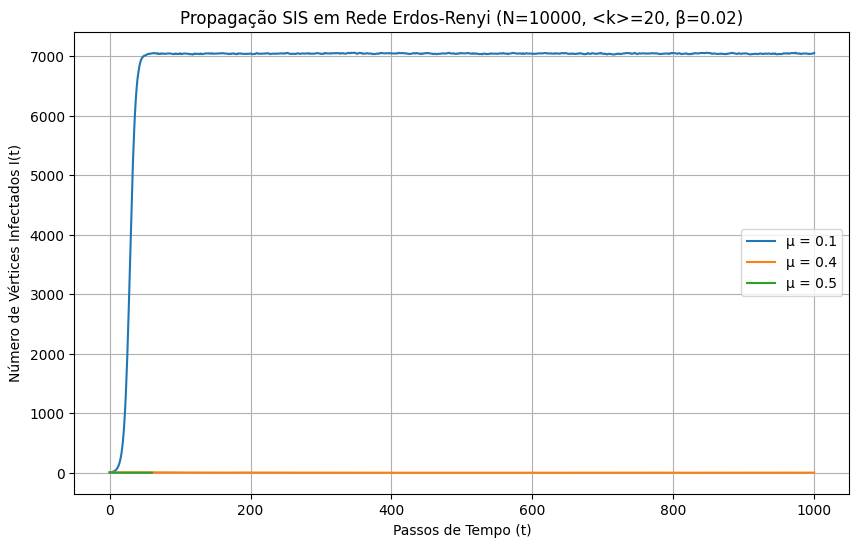

In [11]:
plt.figure(figsize=(10, 6))
plt.title(f'Propagação SIS em Rede Erdos-Renyi (N=10000, <k>=20, β=0.02)')
plt.xlabel('Passos de Tempo (t)')
plt.ylabel('Número de Vértices Infectados I(t)')

# Itera sobre os cenários e plota cada um
for mu, history in scenarios.items():
    # Remove os zeros extras do array, mantendo apenas a simulação
    history_trimmed = history[history != 0]
    
    # Adiciona a última etapa (0 infectados) se a simulação parou
    if history_trimmed[-1] == 0 and len(history) > len(history_trimmed):
        history_trimmed = history[:len(history_trimmed) + 1]

    plt.plot(history_trimmed, label=f'μ = {mu}')

plt.grid(True)
plt.legend()
plt.show()

No nosso exemplo o limiar crítico é $\lambda _c = \frac{1}{<k>} = 0.05$

### a\)
Podemos perceber que o caso com $\mu = 0.1$ teve um cescimento de início exponencial no número de infectados, até que estabilizasse em uma faixa de 7000 mil infectados em média, mantendo isso até o final do experimento. 

Aqui a taxa efetiva de infecção é $\lambda = \frac{\beta}{\mu} = \frac{0.02}{0.1} = 0.2 > \lambda _c$

Com isso, podemos concluir que a doença atinge um estado endêmico permanente

### b\)
No caso de $\mu = 0.4$ já temos um exemplo claro de uma curva de infecção que tem um ápice próximo da iteração $t = 150$, e depois diminui a ponto de que antes da iteração $t = 400$ já não há nenhum infectado.  

Aqui a taxa efetiva de infecção é $\lambda = \frac{\beta}{\mu} = \frac{0.02}{0.4} = 0.05 = \lambda _c$

Portanto, com uma taxa de infecção igual ao limiar crítico, temos um processo de infecção estocástico equilibrado

### c\)
Por fim, para $\mu = 0.5$, a alta taxa de recuperação garantiu que a infecção não se proliferasse, a ponto de que o número de infectados aumentasse em apenas dois e logo decaísse para zero antes da décima iteração.

Aqui a taxa efetiva de infecção é $\lambda = \frac{\beta}{\mu} = \frac{0.02}{0.5} = 0.04 < \lambda _c$

Essa taxa de infecção não permite que a doença de espalhe, e faz com que ela desapareça quase que imediatamente

Gráficos detalhados podem ser vistos abaixo:

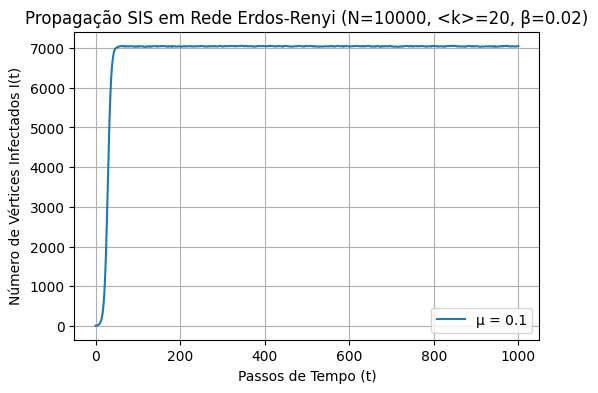

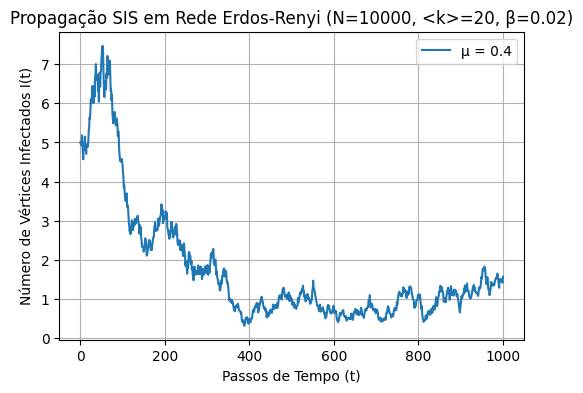

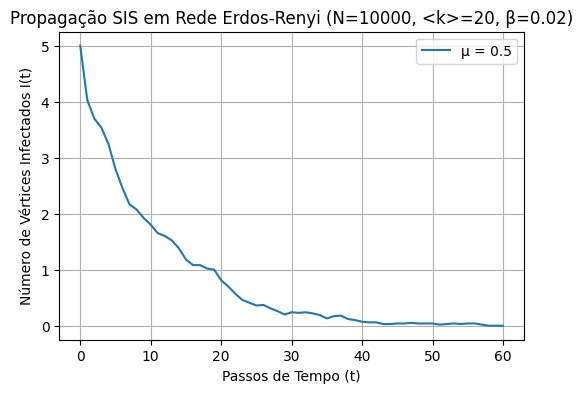

In [12]:
for mu, history in scenarios.items():
    # Remove os zeros extras do array, mantendo apenas a simulação
    history_trimmed = history[history != 0]
    
    # Adiciona a última etapa (0 infectados) se a simulação parou
    if history_trimmed[-1] == 0 and len(history) > len(history_trimmed):
        history_trimmed = history[:len(history_trimmed) + 1]

    plt.figure(figsize=(6, 4))
    plt.title(f'Propagação SIS em Rede Erdos-Renyi (N=10000, <k>=20, β=0.02)')
    plt.xlabel('Passos de Tempo (t)')
    plt.ylabel('Número de Vértices Infectados I(t)')

    plt.plot(history_trimmed, label=f'μ = {mu}')
    plt.grid(True)
    plt.legend()
    plt.show()

---
## Exercício 2
Gere uma rede “livre de escala” com $10000$ vértices, grau médio $<k>= 20$ e 
expoente $\gamma = 2.5$. Comece com $5$ vértices infectados escolhidos aleatoriamente. Execute
múltiplas simulações da propagação da infecção pelo modelo SIS com os parâmetros abaixo e 
compare com os resultados esperados. (sugestão: faça em torno de $100$ simulações e descreva 
o comportamento da epidemia “na média”)

a) $\beta = 0.01$ e $\mu = 0.1$

b) $\beta = 0.01$ e $\mu = 0.2$

c) $\beta = 0.01$ e $\mu = 0.3$

Descreva o comportamento da epidemia e compare com o item (1)

In [13]:
# Parâmetros
N = 10000
k = 20                  # grau médio desejado
m = k // 2              # em BA, <k> ≈ 2m
beta = 0.01             # taxa de infecção base (fixa)
initially_infected_num = 5
num_simulations = 100   # número de simulações por cenário
max_iter = 1000

# Rede que iremos utilizar
degree_sequence = nx.utils.powerlaw_sequence(N, exponent=2.5)
degree_sequence = np.array(degree_sequence)
degree_sequence = degree_sequence / degree_sequence.mean() * 20
degree_sequence = np.maximum(1, degree_sequence.astype(int))
if degree_sequence.sum() % 2 == 1:
    degree_sequence[0] += 1

G = nx.configuration_model(degree_sequence)
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))
adj_matrix = nx.to_scipy_sparse_array(G)

# Cenários de recuperação
scenarios_mu = [0.1, 0.2, 0.3]
results = {mu: np.zeros(max_iter + 1) for mu in scenarios_mu}

In [14]:
for mu in scenarios_mu:

    all_runs = np.zeros((num_simulations, max_iter + 1))

    for sim in range(num_simulations):

        states = np.zeros(N)
        initially_infected = np.random.choice(N, initially_infected_num, replace=False)
        states[initially_infected] = 1

        all_runs[sim, 0] = initially_infected_num

        for t in range(max_iter):
            if np.sum(states) == 0:
                all_runs[sim, t+1:] = 0
                break

            infected_neighbors_count = adj_matrix @ states
            
            prob_infection = 1 - (1 - beta) ** infected_neighbors_count
            
            infection_rolls = np.random.random(N)
            new_infections = (states == 0) & (infection_rolls < prob_infection)
            
            infected_indices = np.where(states == 1)[0]
            recover_probs = np.random.random(len(infected_indices))
            recovering = infected_indices[recover_probs < mu]
            
            states[recovering] = 0
            states[new_infections] = 1
            
            num_infected = np.sum(states)
            all_runs[sim, t+1] = num_infected

    results[mu] = np.mean(all_runs, axis=0)

print(results.items())

dict_items([(0.1, array([   5.  ,    5.21,    7.65, ..., 3360.27, 3356.1 , 3359.46],
      shape=(1001,))), (0.2, array([   5.  ,    4.75,    6.63, ..., 1186.91, 1190.35, 1189.24],
      shape=(1001,))), (0.3, array([  5.  ,   4.25,   7.75, ..., 438.45, 439.15, 438.52], shape=(1001,)))])


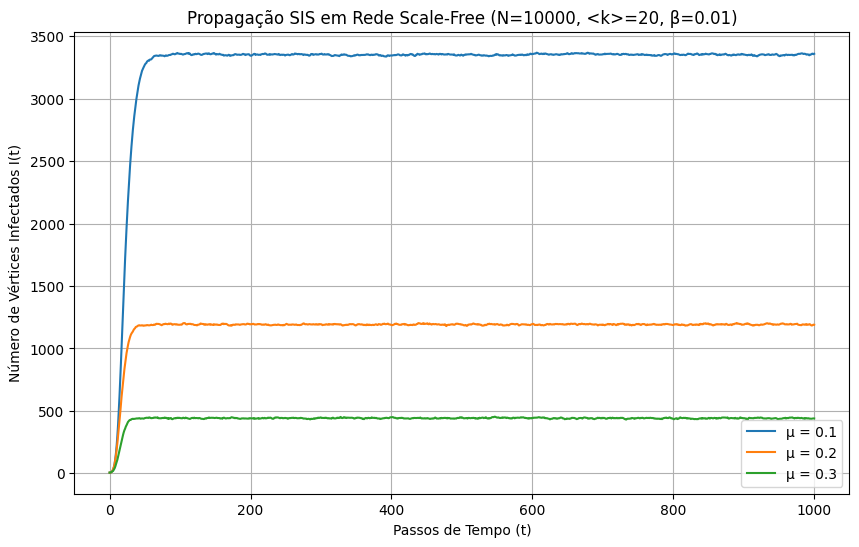

In [15]:
plt.figure(figsize=(10, 6))
plt.title(f'Propagação SIS em Rede Scale-Free (N=10000, <k>=20, β=0.01)')
plt.xlabel('Passos de Tempo (t)')
plt.ylabel('Número de Vértices Infectados I(t)')

# Itera sobre os cenários e plota cada um
for mu, history in results.items(): 
    
    # Remove os zeros extras do array (simulações que terminaram cedo)
    history_trimmed = history[history != 0]
    
    # Mantém o último zero real se a epidemia extinguiu
    if len(history_trimmed) > 0 and history_trimmed[-1] != 0:
        history_trimmed = history
    else:
        first_zero_index = np.where(history == 0)[0][0]
        history_trimmed = history[:first_zero_index + 1]

    plt.plot(history_trimmed, label=f'μ = {mu}')

plt.grid(True)
plt.legend()
plt.show()

Redes livres de escala com expoente $\gamma \le 3$ têm limiar crítico $R_{0,c} = 0$. Isso quer dizer que a rede não tem limiar epidêmico: mesmo valores muito baixos de $\beta$ podem sustentar uma epidemia, porque a infecção fica “presa” nos hubs. Assim, podemos perceber que, nos três casos, a epidemia não cessou, pois tomamos $\gamma = 2.5$. Para nossos calculos, usaremos $R_0$, porém em redes livres de escala temos que $R_0 = \frac{\beta}{\mu} \frac{<k²>}{<k>}$. Por isso, precisamos calcular $\frac{<k²>}{<k>}$.

$<k> \approx k_{min} \frac{\gamma - 1}{\gamma - 2}$

$20 = k_{min} \frac{1.5}{0.5} \to 20 = 3k_{min} \to k_{min} \approx 6.7$

$k_{max} \approx k_{min} N ^{\frac{1}{\gamma - 1}} \approx 6.7 \times 10000 ^{\frac{1}{1.5}} \approx 6.7 \times 10000^{0.66} \approx 6.7 \times 464 \approx 3108$

$<k²> \approx k_{min}^{2} \frac{\gamma - 1}{3 - \gamma} [(\frac{k_{max}}{k_{min}})^{3 - \gamma} - 1] \approx (6.7)^{2} \frac{1.5}{0.5} [(464)^{0.5} - 1] \approx 44.9 \times 3 \times [21.5 - 1] \approx 134.7 \times 20.5 \approx 2761$

$\frac{<k^2>}{<k>} = \frac{2761}{20} \approx 138$.

Além disso, usaremos o C calibrado pelo empírico da $a$ para calcularmos o esperado teórico. Temos que $\lambda = \frac{\beta}{\mu} = \frac{0.01}{0.1} = 0.1$ e o valor emcontrado foi aproximadamente 4000, logo teremos $\rho _a = \frac{4000}{10000} = 0.4 \to 0.4 = C (0.1)^2 \to C = \frac{0.4}{0.01} = 40$

Assim, é possível observar algumas diferenças importantes:

### a\)
O caso $\mu = 0.1$ teve um crescimento inicial exponencial, e a epidemia se fixou em torno de 4000 infectados. Aqui, o número básico de reprodução efetivo foi

$R_0 = \frac{0.01}{0.1} 138 = 13.8$

Como $R_0 = 13.8 \gg 1$, o sistema é extremamente supercrítico, ou seja, a estrutura livre de escala amplifica ainda mais a disseminação, pois os hubs têm alta capacidade de transmitir. Por isso, o platô alcançado é alto.

Pela previsão via lei da potência assintótica ($\rho \approx C \lambda ^2$), temos que $\rho = 40 \times 0.1^2 = 0.4$. Logo, o esperado teórico é de $0.4 \times 10000 = 4000$, o que coincide, como o C foi definido com base em a

### b\)
O caso $\mu = 0.2$ também começou com crescimento rápido, mas a epidemia se estabilizou em torno de 1600 infectados, bem menos que o caso anterior, porque a recuperação mais rápida reduz o tempo infeccioso médio.

$R_0 = \frac{0.01}{0.2} 138 = 6.9$

Nesse regime, o sistema continua supercrítico, porém menos explosivo do que em a, pois a redução do tempo infeccioso corta caminhos potenciais de transmissão, e muitos hubs deixam de manter cadeias longas porque os infectados se recuperam antes de repassar a infecção para um grande número de vizinhos. Assim, a rede ainda sustenta uma epidemia persistente, mas significativamente menor.

Pela previsão via lei da potência assintótica ($\rho \approx C \lambda ^2$), temos que $\lambda = \frac{0.01}{0.2} = 0.05$, com isso $\rho = 40 \times 0.05^2 = 0.1$. Logo, o esperado teórico é de $0.1 \times 10000 = 1000$, o que é um pouco abaixo do empírico. Isso ocorre porque a lei assintótica $\rho \approx \lambda ^{3 - \gamma}$ é válida apenas no limite $\lambda \to 0$. Aqui, $ \lambda = 0.05$ ainda é relativamente grande, e estamos longe do regime assintótico puro. Assim, o valor empírico tende mesmo a ficar acima da previsão assintótica.

### c\)
A epidemia cresceu inicialmente, mas se fixou em torno de 500 infectados, número bem menor pela recuperação mais rápida — a taxa de cura alta reduz drasticamente o tamanho médio da cadeia de transmissão.

$R_0 = \frac{0.01}{0.3} 138 = 4.6$

Com uma taxa de recuperação ainda maior, o regime continua supercrítico, mas agora moderadamente supercrítico: embora ainda haja hubs que sustentam a transmissão, o tempo entre infecção e recuperação é tão curto que muitos potenciais caminhos de espalhamento não chegam a se ativar. Assim, a epidemia persiste, mas num nível endêmico pequeno, e a influência dos hubs é fortemente reduzida.

Pela previsão via lei da potência assintótica ($\rho \approx C \lambda ^2$), temos que $\lambda = \frac{0.01}{0.3} = 0.0333$, com isso $\rho = 40 \times 0.0333^2 = 0.0444$. Logo, o esperado teórico é de $0.444 \times 10000 = 444$, o que é um pouco abaixo do empírico. Isso ocorre pelos mesmos motivos do caso (b), mas agora de forma mais sutil: embora $\lambda$ seja menor e mais próximo do regime assintótico, ainda há efeitos de estrutura real da rede, que elevam a prevalência acima da previsão teórica perfeita. Assim, o valor empírico próximo de 500 fica razoavelmente acima da previsão assintótica de 444, mas ainda muito bem alinhado com a teoria para redes livres de escala com $\gamma = 2.5$

Abaixo, temos um gráfico que faz uma comparação direta entre as questões 1 e 2, trazendo os dados da infecção do modelo ER e do Scale-free

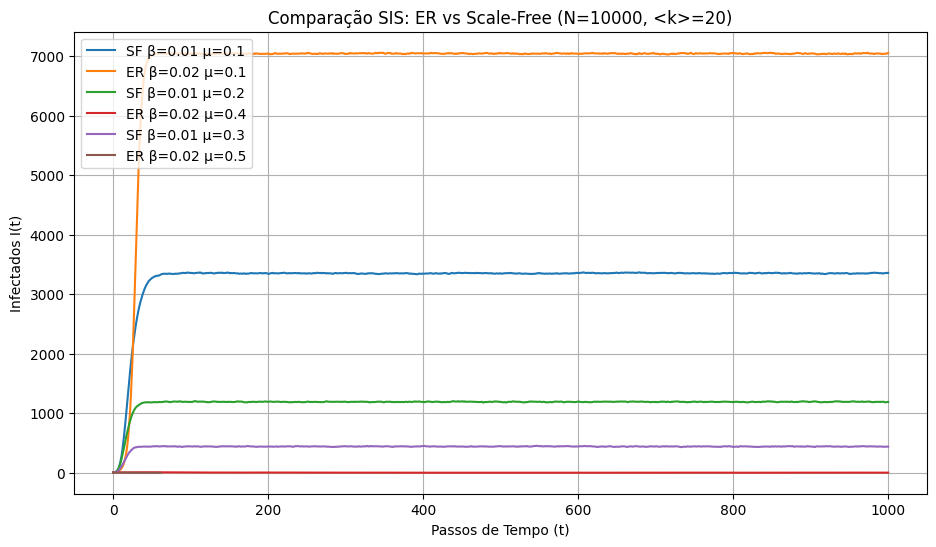

In [16]:
plt.figure(figsize=(11, 6))
plt.title('Comparação SIS: ER vs Scale-Free (N=10000, <k>=20)')
plt.xlabel('Passos de Tempo (t)')
plt.ylabel('Infectados I(t)')

mu = [0.1, 0.1, 0.2, 0.4, 0.3, 0.5]

for i in range(3):

    # ER
    h_er = scenarios[mu[2*i+1]]
    first_zero_er = np.where(h_er == 0)[0]
    if len(first_zero_er) > 0:
        h_er = h_er[:first_zero_er[0] + 1]

    # SF
    h_sf = results[mu[2*i]]
    first_zero_sf = np.where(h_sf == 0)[0]
    if len(first_zero_sf) > 0:
        h_sf = h_sf[:first_zero_sf[0] + 1]

    plt.plot(h_sf, '-', label=f'SF β=0.01 μ={mu[2*i]}')
    plt.plot(h_er, '-', label=f'ER β=0.02 μ={mu[2*i+1]}')

plt.grid(True)
plt.legend()
plt.show()

---
## Exercício 3
Considere o exercício anterior, letra a. Descubra o número de vértices imunizados 
previamente que são necessários para impedir a fixação do estado endêmico nos seguintes 
cenários:

a) Os vértices imunizados são escolhidos aleatoriamente. 

b) Os vértices imunizados são os de maior grau (hubs). 

c) Os vértices imunizados são os vizinhos de vértices escolhidos aleatoriamente.

Descreva (brevemente, com um ou dois parágrafos) como a fração de vacinados em cada caso
se relaciona com o tema de robustez da rede visto em sala de aula

In [17]:
# Parâmetros
N = 10000
k = 20
p = k / N

beta = 0.01
mu = 0.1
initial_infected = 5
num_simulations = 100   # número de simulações por cenário
max_iter = 1000

# Rede que iremos utilizar
degree_sequence = nx.utils.powerlaw_sequence(N, exponent=2.5)
degree_sequence = np.array(degree_sequence)
degree_sequence = degree_sequence / degree_sequence.mean() * 20
degree_sequence = np.maximum(1, degree_sequence.astype(int))
if degree_sequence.sum() % 2 == 1:
    degree_sequence[0] += 1

G = nx.configuration_model(degree_sequence)
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))
adj_matrix = nx.to_scipy_sparse_array(G)

In [18]:
def run_sis(G, immunized_set):    
    is_immunized = np.zeros(N, dtype=bool)
    if immunized_set:
        is_immunized[list(immunized_set)] = True

    available_nodes = np.where(~is_immunized)[0]
    states = np.zeros(N)
    
    initial = np.random.choice(available_nodes, initial_infected, replace=False)
    states[initial] = 1

    for t in range(max_iter):
        
        if np.sum(states) == 0:
            return 0

        infected_neighbors_count = adj_matrix @ states
        
        prob_infection = 1 - (1 - beta) ** infected_neighbors_count
        
        infection_rolls = np.random.random(N)
        
        # Só infecta se: for suscetível (0) E a chance bater E não for imunizado
        new_infections = (states == 0) & (infection_rolls < prob_infection) & (~is_immunized)
        
        infected_indices = np.where(states == 1)[0]
        recover_probs = np.random.random(len(infected_indices))
        recovering = infected_indices[recover_probs < mu]

        states[new_infections] = 1
        states[recovering] = 0

    return np.sum(states)

In [19]:
fractions = np.linspace(0, 0.75, 30)
results_random = {}
results_hubs = {}
results_neighbors = {}

sorted_by_degree = [n for n, d in sorted(G.degree(), key=lambda x: x[1], reverse=True)]

for frac in fractions:
    print(f"Testando fração de vacinação = {frac:.3f}")
    num_vaccinated = int(frac * N)
    
    if num_vaccinated == 0:
        base_val = np.mean([run_sis(G, set()) for _ in range(num_simulations)])
        results_random[frac] = results_hubs[frac] = results_neighbors[frac] = base_val
        continue

    immunized_random = set(random.sample(range(N), num_vaccinated))

    immunized_hubs = set(sorted_by_degree[:num_vaccinated])

    vacc_neighbors = set()
    candidates = np.random.permutation(N)
    idx = 0
    while len(vacc_neighbors) < num_vaccinated and idx < N:
        vacc_neighbors.update(G[candidates[idx]])
        idx += 1
    
    immunized_neighbors = set(list(vacc_neighbors)[:num_vaccinated])

    results_random[frac] = np.mean([run_sis(G, immunized_random) for _ in range(num_simulations)])
    results_hubs[frac] = np.mean([run_sis(G, immunized_hubs) for _ in range(num_simulations)])
    results_neighbors[frac] = np.mean([run_sis(G, immunized_neighbors) for _ in range(num_simulations)])

print("\nFrações testadas:", fractions)
print("\nVacinação aleatória:", results_random)
print("\nVacinação hubs:", results_hubs)
print("\nVacinação vizinhos:", results_neighbors)

Testando fração de vacinação = 0.000
Testando fração de vacinação = 0.026
Testando fração de vacinação = 0.052
Testando fração de vacinação = 0.078
Testando fração de vacinação = 0.103
Testando fração de vacinação = 0.129
Testando fração de vacinação = 0.155
Testando fração de vacinação = 0.181
Testando fração de vacinação = 0.207
Testando fração de vacinação = 0.233
Testando fração de vacinação = 0.259
Testando fração de vacinação = 0.284
Testando fração de vacinação = 0.310
Testando fração de vacinação = 0.336
Testando fração de vacinação = 0.362
Testando fração de vacinação = 0.388
Testando fração de vacinação = 0.414
Testando fração de vacinação = 0.440
Testando fração de vacinação = 0.466
Testando fração de vacinação = 0.491
Testando fração de vacinação = 0.517
Testando fração de vacinação = 0.543
Testando fração de vacinação = 0.569
Testando fração de vacinação = 0.595
Testando fração de vacinação = 0.621
Testando fração de vacinação = 0.647
Testando fração de vacinação = 0.672
T

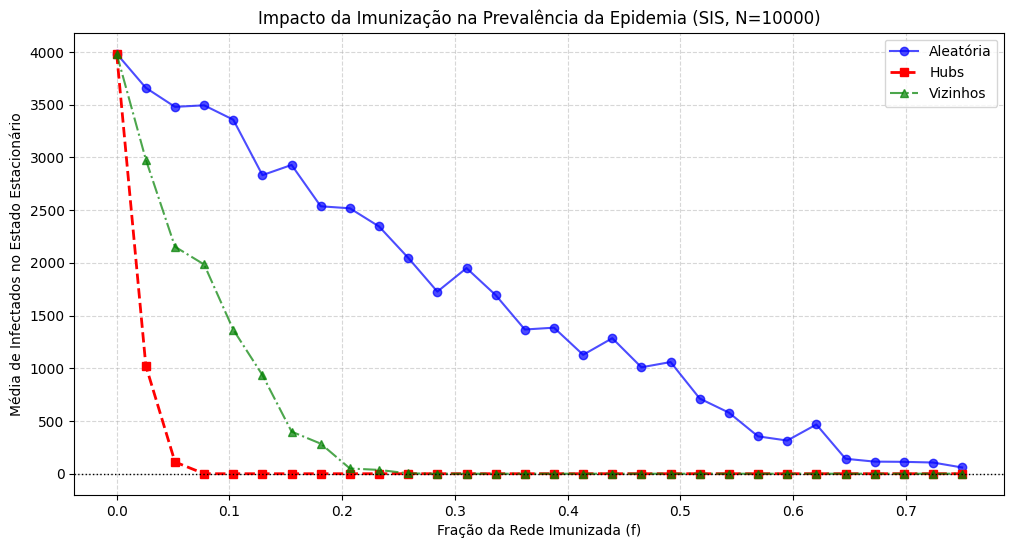

In [20]:
plt.figure(figsize=(12, 6))

# Garante que vamos plotar na ordem correta do eixo X (fração de vacinados)
sorted_fracs = sorted(fractions)

# Função auxiliar para extrair os valores na ordem das frações
def get_y_values(results_dict):
    return [results_dict[f] for f in sorted_fracs]

# Plotagem das 3 curvas
plt.plot(sorted_fracs, get_y_values(results_random), 
         marker='o', linestyle='-', label='Aleatória', color='blue', alpha=0.7)

plt.plot(sorted_fracs, get_y_values(results_hubs), 
         marker='s', linestyle='--', label='Hubs', color='red', linewidth=2)

plt.plot(sorted_fracs, get_y_values(results_neighbors), 
         marker='^', linestyle='-.', label='Vizinhos', color='green', alpha=0.7)

# Detalhes estéticos
plt.axhline(0, color='black', linewidth=1, linestyle=':') # Linha de referência zero
plt.title(f'Impacto da Imunização na Prevalência da Epidemia (SIS, N={N})')
plt.xlabel('Fração da Rede Imunizada (f)')
plt.ylabel('Média de Infectados no Estado Estacionário')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Quando os nós imunizados são escolhidos aleatoriamente, a fração necessária de vacinação para impedir a fixação do estado endêmico tende a ser alta, pois esse tipo de vacinação nao afeta de forma significativa os nós de maior grau; no caso empírico que fizemos, 0.73, que equivale a $0.73 \times 10000 = 7300$ pessoas imunuzadas. Isso ocorre porque, como a remoção é homogênea, ela não atinge preferencialmente os nós estruturalmente mais importantes da rede. Esse tipo de vacinação corresponde a um cenário de ataque aleatório, e as redes livres de escala são altamente resistentes a ataques aleatórios, pois sua estrutura tem muitos nós de grau baixo e poucos hubs, que quase nunca são removidos aleatoriamente (por exemplo, se houver apenas ~200 hubs entre 10000 nós, a chance de removê-los aleatoriamente é apenas 2%); assim, mesmo vacinando grante parte da população, os hubs ativos continuam sistentando a epidemia. Esse resultado ilustra diretamente a robustez das redes livres de escala contra falhas aleatórias, que preservam a conectividade mesmo após remoções extensas.

Por outro lado, quando damos preferencia à imunização dos hubs, mesmo uma pequena fração de vacinação elimina rapidamente a transmissão, no nosso caso, aproximadamente 0.03 ($0.03 \times 10000 = 300$ pessoas imunuzadas). Isso equivale a um ataque direcionado às pessoas de maior contato, e acontece porque os hubs têm grau dezenas de vezes maior que a média (por exemplo, o grau médio é 20, mas hubs podes ter grau maior que 200), e a imunização deles reduz drasticamente os caminhos que o vírus pode circular, diminuindo a conectividade global. Isso reflete a extrema fragilidade das redes livres de escala a ataques direcionados, onde remover poucos vértices críticos já destrói a estrutura global da rede. Já quando vacinamos os vizinhos de um vértice aleatório, é possível observar um efeito intermediário, no nosso caso a fração é de 0.15 que equivale a $0.15 \times 10000 = 1500$ pessoas imunuzadas; isso ocorre pois esse estilo de vacinação tende a imunizar nós com grau acima da média, mas não necessáriamente os hubs, o que o faz precisar de uma fração menos que vacinar vértices aleatórios, mas não ser tão bom quanto imunizar os hubs. Esse comportamento intermediário se alinha com a robustez parcial da rede: ela perde eficiência estrutural mais rápido que sob ataque aleatório, mas ainda resiste mais do que sob remoção direcionada dos hubs.